# HW3: Extended Yale Faces B Database - Eigenfaces
---
Supervised, and unsupervised clustering algorithms are used on the extended yale faces dataset. Individual identification is explored, as are gender groupings to an extent. The homework finds that generalisable models can be created using this dataset, and a discussion on facial dimensions is had.

## Ugly initialisations and library stuff

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import os
import glob
import random
import sklearn.neighbors
import sklearn.model_selection
import sklearn.metrics
import sklearn.naive_bayes
import sklearn.svm
import sklearn.cluster

In [2]:
# My Colour scheme
#  every self-respecting/loathing millenial has their own, right?
orange = '#FFA500'
millenialPink = '#FFAADD'
mediumAquamarine = '#66CDAA'

# Custom cmap
from matplotlib.colors import LinearSegmentedColormap

colours = [orange,millenialPink]
cm = LinearSegmentedColormap.from_list('customCmap', colours, N=1024)

## Data setup
Data given is for uncropped and cropped images. They both come in weird and different formats. Fucntions to load each respectively are created to avoid this awkwardness and allow for easy and discritsed access as they are as equally large as they are isotetically formatted.

In [3]:
def PGMtoArray(filePath,dtype=np.int16):
    im = PIL.Image.open(filePath)
    return np.array(im,dtype=dtype)

def PGMtoVector(filePath,dtype=np.int16):
    im = PGMtoArray(filePath,dtype=dtype)
    return im.reshape(im.shape[0]*im.shape[1])

def ArrayToPGM(array):
    return PIL.Image.fromarray(array)

def VectorToPGM(vector,cols,rows):
    im = vector.reshape(cols,rows)
    return ArrayToPGM(im)

In [4]:
# Cropped Faces
cTopLevelDir = './Data/CroppedYale'
cCols=192 # From data, hardcoded here
cRows=168
# Save each image nested in face directorys in toplevelDir, with a label of which face
def CroppedLoad(dPath=cTopLevelDir,dirSplitStr='yaleB'):
    # Create array to put all in.
    data = []
    # For each directory found, each new person
    for dirName in os.listdir(dPath):
        label = dirName.split(dirSplitStr)[-1]
        #print('Loading Images for B'+str(label)+'...')
        # For all images found in this directory
        for image in glob.glob(dPath+'/'+dirName+'/*.pgm'):
            im = PGMtoVector(image)
            newRow = np.insert(im,0,label)
            data.append(newRow)
    return np.array(data)
    

In [5]:
# UnCropped Faces
ucTopLevelDir = './DATA/yalefaces_uncropped/yalefaces'
ucCols = 243
ucRows = 320

def UnCroppedLoad(dPath=ucTopLevelDir,splitStr='subject'):
    data = []
    for image in os.listdir(dPath):
        # Find subject label
        label = image.split(splitStr)[-1].split('.')[0]
        # Get vector from filePath
        im = PGMtoVector(dPath+'/'+image)
        newRow = np.insert(im,0,label)
        data.append(newRow)
    return np.array(data)
    

## SVD Analysis

In [6]:
# Load Data
ucX = UnCroppedLoad()
print(ucX.shape)

(165, 77761)


In [7]:
ucAvg = np.mean(ucX[:,1:],axis=0)

In [8]:
# Remvoe avg
ucX = ucX.astype(float)
ucX[:,1:] -= ucAvg

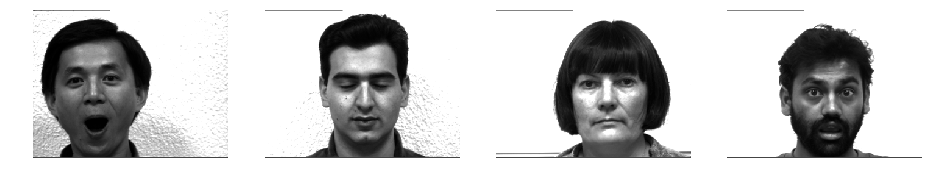

In [9]:
# Plot a few.
toPlot = [2,15,20,42]
f, axs = plt.subplots(1,len(toPlot),figsize=(13,4))
for i in range(len(toPlot)):
    axs[i].imshow(VectorToPGM(ucX[toPlot[i],1:]+ucAvg,ucCols,ucRows))
    axs[i].axis('off')
f.tight_layout()

In [10]:
f.savefig('./Images/ucImages.png')

In [11]:
ucU,ucS,ucVh = np.linalg.svd(ucX[:,1:].T,full_matrices=0)

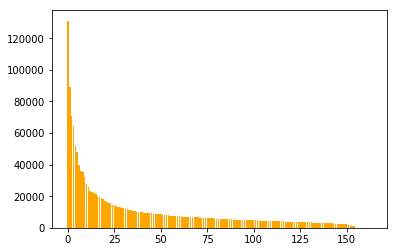

In [12]:
[start,end] = [0,-1]
plt.bar(range(len(ucS[start:end])),ucS[start:end],color=orange)
#plt.xlabel('U mode')
plt.savefig('./Images/ucSingularValue')
plt.show()

In [13]:
ucr = 25
ucrs = [1,5,25,125]

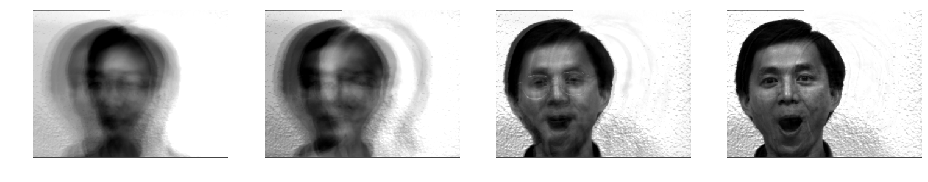

In [14]:
# Plot a few.
f, axs = plt.subplots(1,len(ucrs),figsize=(13,4))
for j in range(len(ucrs)):
    v = ucX[toPlot[0],1:]
    v = ucAvg + ucU[:,:ucrs[j]]  @ (ucU[:,:ucrs[j]].T @ v.T)
    axs[j].imshow(VectorToPGM(v,ucCols,ucRows))
    axs[j].axis('off')
f.tight_layout()
f.savefig('./Images/ucImagesR')

In [15]:
# REMEMBER 1st value in each row is it's label!
cX = CroppedLoad()
print(cX.shape)

(2414, 32257)


In [16]:
cAvg = np.mean(cX[:,1:],axis=0)

In [17]:
# Remvoe avg
cX = cX.astype(float)
cX[:,1:] -= cAvg

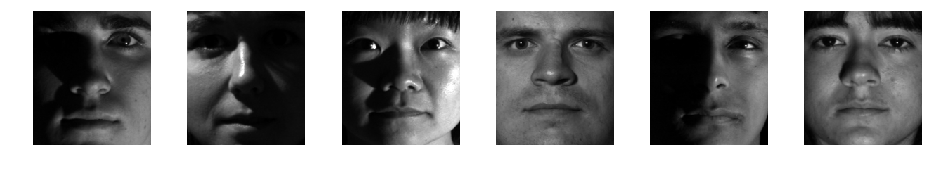

In [18]:
# Plot a few.
toPlot = [0,100,200,300,400,500]
f, axs = plt.subplots(1,len(toPlot),figsize=(13,4))
for i in range(len(toPlot)):
    axs[i].imshow(VectorToPGM(cX[toPlot[i],1:]+cAvg,cCols,cRows))
    axs[i].axis('off')
f.tight_layout()

In [19]:
f.savefig('./Images/cImages.png')

In [20]:
cU,cS,cVh = np.linalg.svd(cX[:,1:].T,full_matrices=0)

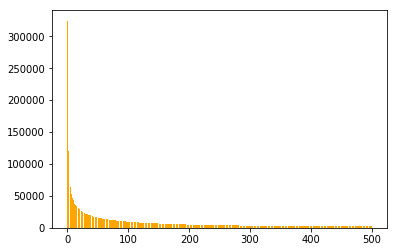

In [21]:
[start,end] = [0,500]
plt.bar(range(len(cS[start:end])),cS[start:end],color=orange)
#plt.xlabel('U mode')
plt.savefig('./Images/cSingularValue')
plt.show()

In [22]:
cr = 250
crs = [1,5,25,50,cr,1000]

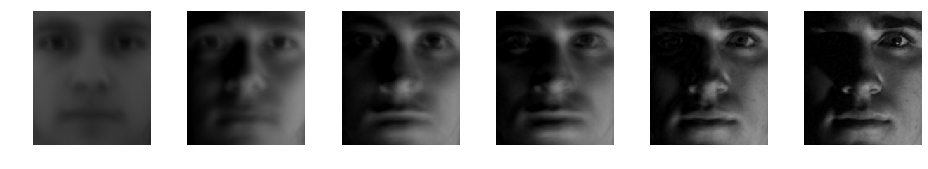

In [23]:
# Plot a few.
f, axs = plt.subplots(1,len(crs),figsize=(13,4))
for j in range(len(crs)):
    v = cX[toPlot[0],1:]
    v = cAvg + cU[:,:crs[j]]  @ (cU[:,:crs[j]].T @ v.T)
    axs[j].imshow(VectorToPGM(v,cCols,cRows))
    axs[j].axis('off')
f.tight_layout()
f.savefig('./Images/cImagesR')

## Feature Investigation


In [24]:
features = [0,1]
cXt = np.zeros((cX.shape[0],len(features)+1))
cXt[:,1:] = (cU[:,features].T @ cX[:,1:].T).T
cXt[:,0] = cX[:,0]
print(cXt.shape)

(2414, 3)


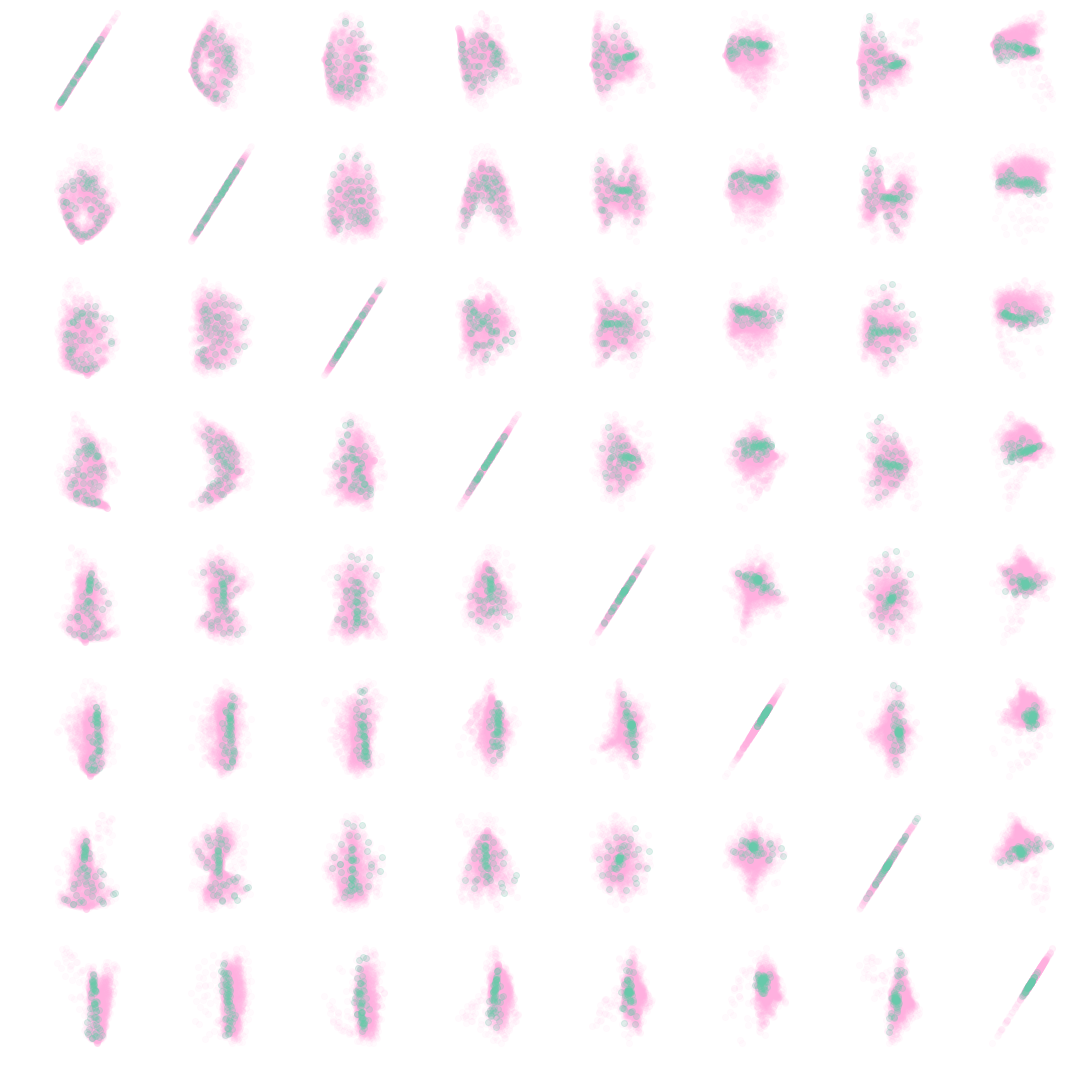

In [25]:
n = 8
testSubject = 1
f, axs = plt.subplots(n,n,figsize=(15,15)) #figsize=(13,4)
for i in range(n):
    for j in range(n):
        x = (cU[:,i].T @ cX[:,1:].T).T
        y = (cU[:,j].T @ cX[:,1:].T).T
        axs[i,j].scatter(x,y,c=millenialPink,alpha=0.05)
        indexes = np.where(cX[:,0]==testSubject)
        axs[i,j].scatter(x[indexes],y[indexes],c=mediumAquamarine,alpha=0.2)
        axs[i,j].axis('off')
f.tight_layout()

In [26]:
# Then save this fella
f.savefig('./featureSearch.png')  

# This does however show no possibility to clustering
#  So 2D are entirely inadequate to cluster on.

(32256,)


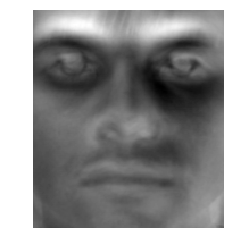

In [27]:
i = 5
print(cU[:,0].shape)
im = cU[:,i].reshape(cCols,cRows)
plt.imshow(im,cmap='gray')
plt.axis('off')
plt.show()

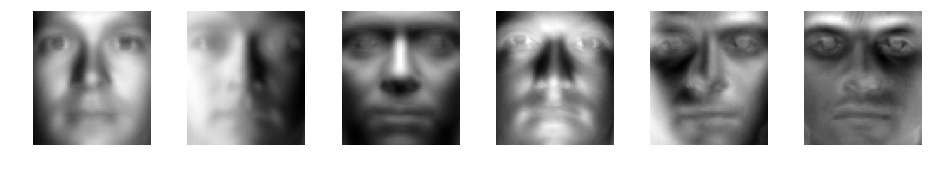

In [28]:
# Plot a few.
n = 6
f, axs = plt.subplots(1,n,figsize=(13,4))
for i in range(n):
    im = (cU[:,i]).reshape(cCols,cRows)
    axs[i].imshow(im,cmap='gray')
    axs[i].axis('off')
f.tight_layout()
f.savefig('./Images/cModes')

## (test 1) Face Classification

### Data wrangling

In [29]:
# Something to make stochastic training sets
def SplitGroupX(X,groupsLabels,outLabels,testQuantities=[128,32]):
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []
    for i in range(len(outLabels)):
        groupIndexes = []
        for a in groupsLabels[i]:
            aIndexes = np.where(X[:,0]==a)[0]
            groupIndexes.extend(aIndexes)
        groupTestIndexes = random.choices(groupIndexes,k=testQuantities[i])
        groupTrainIndexes = [x for x in groupIndexes if x not in groupTestIndexes]
        X_test.extend(groupTestIndexes)
        Y_test.extend(outLabels[i]*np.ones(testQuantities[i]))
        X_train.extend(groupTrainIndexes)
        Y_train.extend(outLabels[i]*np.ones(len(groupTrainIndexes)))
    return np.array(X[X_train,1:]),np.array(Y_train),np.array(X[X_test,1:]),np.array(Y_test)     

In [30]:
# Suitably truncate data
r = 100
cXt = np.zeros((cX.shape[0],r+1))
cXt[:,1:] = (cU[:,:r].T @ cX[:,1:].T).T
cXt[:,0] = cX[:,0]
print(cXt.shape)

(2414, 101)


(100,)
(32256, 100)
(32256,)


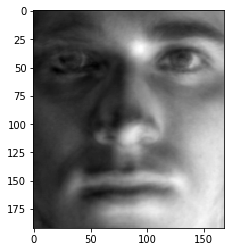

In [31]:
print(cXt[0,1:].shape)
print(cU[:,:100].shape)
im = cU[:,:100] @ cXt[0,1:]
im += cAvg
print(im.shape)
im = im.reshape(cCols,cRows)
plt.imshow(im,cmap='gray')

In [32]:
N = 39

# Create training sets using a subset of both persons and images of those persons
#  training includes excluded invidiauls and images of individuals in training
def LeavoutX(X,groupsLabels,outLabels,testQuantities=[128,32],leaveoutN=1):
    group0 = groupsLabels[0]
    random.shuffle(group0)
    leaveout0=[]
    if leaveoutN < len(groupsLabels[0]):
        leaveout0 = group0[-leaveoutN:]
        group0 = [x for x in group0 if x not in leaveout0]
    
    group1 = groupsLabels[1]
    random.shuffle(group1)
    leaveout1=[]
    if leaveoutN < len(groupsLabels[1]):
        leaveout1 = group1[-leaveoutN:]
        group1 = [x for x in group1 if x not in leaveout1]
    
    X_train,Y_train,X_test,Y_test = SplitGroupX(X,[group0,group1],outLabels,testQuantities)
    
    
    X_test = list(X_test)
    Y_test = list(Y_test)
    
    for a in leaveout0:
        aIndexes = np.where(X[:,0]==a)[0]
        X_test.extend(X[aIndexes,1:])
        Y_test.extend(outLabels[0]*np.ones(aIndexes.shape[0]))
        
    for a in leaveout1:
        aIndexes = np.where(X[:,0]==a)[0]
        X_test.extend(X[aIndexes,1:])
        Y_test.extend(outLabels[1]*np.ones(aIndexes.shape[0]))

    X_test = np.array(X_test)
    Y_test = np.array(Y_test)
    
    return X_train,Y_train,X_test,Y_test

In [33]:
# Stolen from online
#  https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          precision=3):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    #for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, round(cm[i, j],precision),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### KNN

In [34]:
# Create the groups
N = 7
group2 = [1]
group1 = [x for x in range(1,N) if x not in group2]

In [35]:
X_train,Y_train,X_test,Y_test = LeavoutX(cXt,[group1,group2],[-1,1],leaveoutN=10)
print([X_train.shape,Y_train.shape,X_test.shape,Y_test.shape])

[(253, 100), (253,), (160, 100), (160,)]


(256, 2, 2)
[[0.85150825 0.14849175]
 [0.57263184 0.42736816]]
Confusion matrix, without normalization
[[0.85150825 0.14849175]
 [0.57263184 0.42736816]]


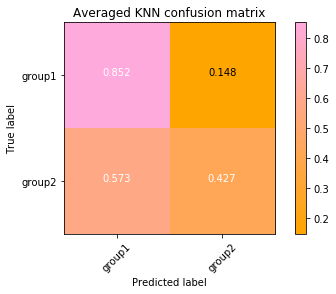

In [36]:
# Avg. KNN
cmList = []
k = 256
for i in range(k):
    X_train,Y_train,X_test,Y_test = LeavoutX(cXt,[group1,group2],[-1,1],leaveoutN=2,testQuantities=[16,64])
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train,Y_train)
    predictions = knn.predict(X_test)
    confMat = sklearn.metrics.confusion_matrix(Y_test,predictions,normalize='true')
    cmList.append(confMat)
cmList = np.array(cmList)
print(cmList.shape)
cmMean = np.mean(cmList,axis=0)
print(cmMean)
plot_confusion_matrix(cmMean,['group1','group2'],title='Averaged KNN confusion matrix',cmap=cm)
plt.savefig('./Images/knnTest1_7.png')

(256, 2, 2)
[[0.92296007 0.07703993]
 [0.4331665  0.5668335 ]]
Confusion matrix, without normalization
[[0.92296007 0.07703993]
 [0.4331665  0.5668335 ]]


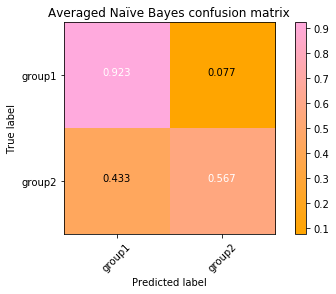

In [37]:
# Avg. NB
cmList = []
k = 256
for i in range(k):
    X_train,Y_train,X_test,Y_test = LeavoutX(cXt,[group1,group2],[-1,1],leaveoutN=2,testQuantities=[16,128])
    nb = sklearn.naive_bayes.GaussianNB()
    nb.fit(X_train,Y_train)
    predictions = knn.predict(X_test)
    confMat = sklearn.metrics.confusion_matrix(Y_test,predictions,normalize='true')
    cmList.append(confMat)
cmList = np.array(cmList)
print(cmList.shape)
cmMean = np.mean(cmList,axis=0)
print(cmMean)
plot_confusion_matrix(cmMean,['group1','group2'],title='Averaged Naïve Bayes confusion matrix',cmap=cm)
plt.savefig('./Images/nbTest1.png')

(256, 2, 2)
[[0.91305881 0.08694119]
 [0.43838501 0.56161499]]
Confusion matrix, without normalization
[[0.91305881 0.08694119]
 [0.43838501 0.56161499]]


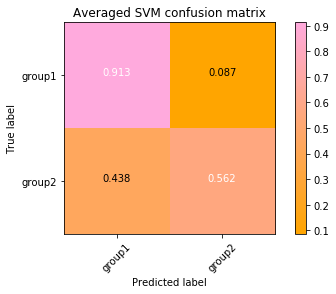

In [38]:
# Avg. SVM
cmList = []
k = 256
for i in range(k):
    X_train,Y_train,X_test,Y_test = LeavoutX(cXt,[group1,group2],[-1,1],leaveoutN=2,testQuantities=[16,128])
    svm = sklearn.svm.SVC()
    svm.fit(X_train,Y_train)
    predictions = knn.predict(X_test)
    confMat = sklearn.metrics.confusion_matrix(Y_test,predictions,normalize='true')
    cmList.append(confMat)
cmList = np.array(cmList)
print(cmList.shape)
cmMean = np.mean(cmList,axis=0)
print(cmMean)
plot_confusion_matrix(cmMean,['group1','group2'],title='Averaged SVM confusion matrix',cmap=cm)
plt.savefig('./Images/svmTest1.png')

0.6470588235294118
[[0.81944444 0.18055556]
 [0.546875   0.453125  ]]


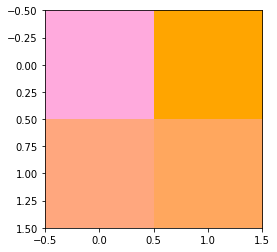

In [39]:
predictions = knn.predict(X_test)
#print(predictions)
score = knn.score(X_test,Y_test)
print(score)
confMat = sklearn.metrics.confusion_matrix(Y_test,predictions,normalize='true')
print(confMat)
plt.imshow(confMat,cmap=cm)
plt.show()

## Gender, somewhat

In [40]:
# Two groups of real human people
N = 39
group1 = [5,15,22,27,28,32,34,37]
group2 = [x for x in range(1,N) if x not in group1]
group2 = group2[:len(group1)]

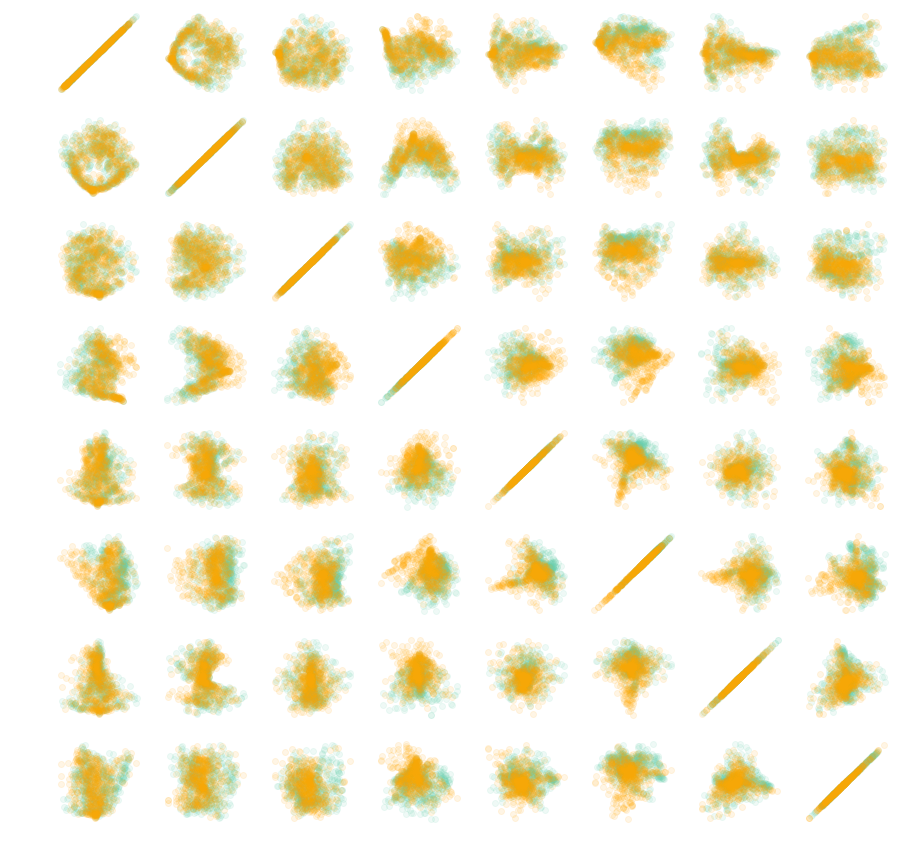

In [41]:
# Another feature selection search
n = 8
f, axs = plt.subplots(n,n,figsize=(15,15)) #figsize=(13,4)
for i in range(n):
    for j in range(n):
        x = (cU[:,i].T @ cX[:,1:].T).T
        y = (cU[:,j].T @ cX[:,1:].T).T
        for a in group2:
            indexes = np.where(cX[:,0]==a)
            axs[i,j].scatter(x[indexes],y[indexes],c=mediumAquamarine,alpha=0.1)
        for a in group1:
            indexes = np.where(cX[:,0]==a)
            axs[i,j].scatter(x[indexes],y[indexes],c=orange,alpha=0.1)
        axs[i,j].axis('off')

In [42]:
f.tight_layout()
f.savefig('./Images/featureSearchGender.png')

(256, 2, 2)
[[0.72578867 0.27421133]
 [0.14524841 0.85475159]]
Confusion matrix, without normalization
[[0.72578867 0.27421133]
 [0.14524841 0.85475159]]


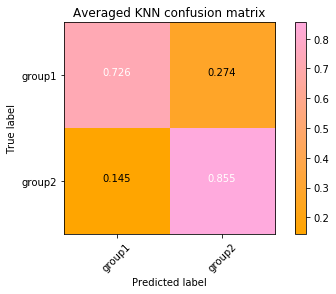

In [43]:
# Avg. KNN
cmList = []
k = 256
for i in range(k):
    X_train,Y_train,X_test,Y_test = LeavoutX(cXt,[group1,group2],[-1,1],leaveoutN=2,testQuantities=[128,128])
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train,Y_train)
    predictions = knn.predict(X_test)
    confMat = sklearn.metrics.confusion_matrix(Y_test,predictions,normalize='true')
    cmList.append(confMat)
cmList = np.array(cmList)
print(cmList.shape)
cmMean = np.mean(cmList,axis=0)
print(cmMean)
plot_confusion_matrix(cmMean,['group1','group2'],title='Averaged KNN confusion matrix',cmap=cm)
plt.savefig('./Images/knnTest2.png')

(256, 2, 2)
[[0.84120053 0.15879947]
 [0.03964233 0.96035767]]
Confusion matrix, without normalization
[[0.84120053 0.15879947]
 [0.03964233 0.96035767]]


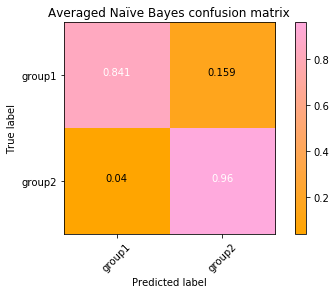

In [44]:
# Avg. NB
cmList = []
k = 256
for i in range(k):
    X_train,Y_train,X_test,Y_test = LeavoutX(cXt,[group1,group2],[-1,1],leaveoutN=2,testQuantities=[128,128])
    nb = sklearn.naive_bayes.GaussianNB()
    nb.fit(X_train,Y_train)
    predictions = knn.predict(X_test)
    confMat = sklearn.metrics.confusion_matrix(Y_test,predictions,normalize='true')
    cmList.append(confMat)
cmList = np.array(cmList)
print(cmList.shape)
cmMean = np.mean(cmList,axis=0)
print(cmMean)
plot_confusion_matrix(cmMean,['group1','group2'],title='Averaged Naïve Bayes confusion matrix',cmap=cm)
plt.savefig('./Images/nbTest2.png')

(256, 2, 2)
[[0.83365866 0.16634134]
 [0.04147339 0.95852661]]
Confusion matrix, without normalization
[[0.83365866 0.16634134]
 [0.04147339 0.95852661]]


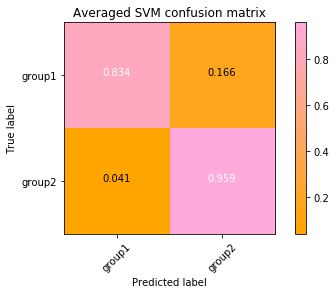

In [45]:
# Avg. SVM
cmList = []
k = 256
for i in range(k):
    X_train,Y_train,X_test,Y_test = LeavoutX(cXt,[group1,group2],[-1,1],leaveoutN=2,testQuantities=[16,128])
    svm = sklearn.svm.SVC()
    svm.fit(X_train,Y_train)
    predictions = knn.predict(X_test)
    confMat = sklearn.metrics.confusion_matrix(Y_test,predictions,normalize='true')
    cmList.append(confMat)
cmList = np.array(cmList)
print(cmList.shape)
cmMean = np.mean(cmList,axis=0)
print(cmMean)
plot_confusion_matrix(cmMean,['group1','group2'],title='Averaged SVM confusion matrix',cmap=cm)
plt.savefig('./Images/svmTest2.png')

## Unsupervised learning

In [46]:
X_train = cXt[:,1:]
X_test = cXt[:,1:]
print([X_train.shape,X_test.shape])

[(2414, 100), (2414, 100)]


In [47]:
# Fit KMeans models
kmeans = sklearn.cluster.KMeans(n_clusters=3)
kmeans.fit(X_train) # Could use everything

KMeans(n_clusters=3)

In [48]:
# Find some predictions
p = kmeans.predict(X_test)

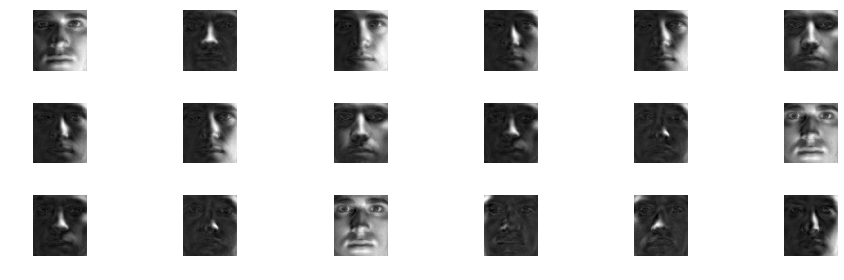

In [49]:
# Plot a few from each group
n = 6
m = 3
f, axs = plt.subplots(m,n,figsize=(13,4))
toPrint = np.where(p==0)[0][:n*m]
#toPrint = [0,3,11,200,199,384]
for j in range(m):
    for i in range(n):
        v = X_test[toPrint[m*j+i]]
        im = cU[:,:r] @ v
        im += cAvg
        im = im.reshape(cCols,cRows)
        axs[j][i].imshow(im,cmap='gray')
        axs[j][i].axis('off')
f.tight_layout()
f.savefig('./Images/unsupervisedGroup0_3')

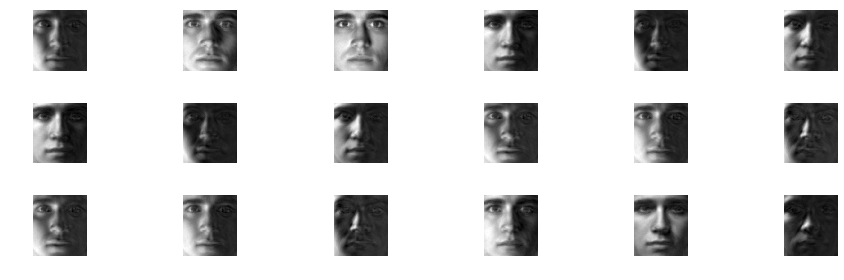

In [50]:
# Plot a few from each group
n = 6
m = 3
f, axs = plt.subplots(m,n,figsize=(13,4))
toPrint = np.where(p==1)[0][:n*m]
#toPrint = [0,3,11,200,199,384]
for j in range(m):
    for i in range(n):
        v = X_test[toPrint[m*j+i]]
        im = cU[:,:r] @ v
        im += cAvg
        im = im.reshape(cCols,cRows)
        axs[j][i].imshow(im,cmap='gray')
        axs[j][i].axis('off')
f.tight_layout()
f.savefig('./Images/unsupervisedGroup1_3')

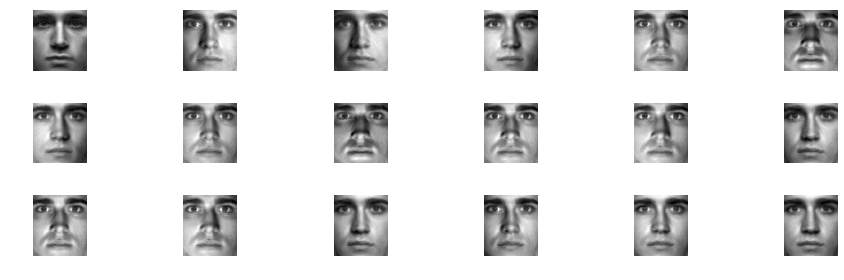

In [51]:
# Plot a few from each group
n = 6
m = 3
f, axs = plt.subplots(m,n,figsize=(13,4))
toPrint = np.where(p==2)[0][:n*m]
#toPrint = [0,3,11,200,199,384]
for j in range(m):
    for i in range(n):
        v = X_test[toPrint[m*j+i]]
        im = cU[:,:r] @ v
        im += cAvg
        im = im.reshape(cCols,cRows)
        axs[j][i].imshow(im,cmap='gray')
        axs[j][i].axis('off')
f.tight_layout()
f.savefig('./Images/unsupervisedGroup2_3')